### *Step 1: Importing necessary libraries*

In [1]:
import re
import pandas as pd

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

from pandas import DataFrame 
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from sklearn.metrics import mean_squared_error

<Figure size 640x480 with 0 Axes>

### *Step 2: Reading the Dataset*

In [2]:
df = pd.read_json('./Data/Appliances.json', lines=True) #with pandas
df.head() #displaying top 5 rows

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,1385510400,NaN
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,1383264000,NaN
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,1381363200,NaN
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,1381276800,NaN
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",1378512000,NaN


In [3]:
#checking the shape
df.shape

(602777, 12)

### *Step 3: Dataset pre-processing*
> Performing **product** based colloborative filtering

In [4]:
#grouping by on product id (which is asin) on bases of count and mean
grp_count = df.groupby("asin", as_index=False).count()
#grp_mean = df.groupby("asin", as_index=False).mean()

#joining the dataframes
df_joined = pd.merge(df, grp_count, how='right', on=['asin'])
df_joined.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,style_x,reviewerName_x,reviewText_x,summary_x,...,vote_y,verified_y,reviewTime_y,reviewerID_y,style_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,image_y
0,5,2,False,"11 27, 2013",A3NHUQ33CFH3VM,1118461304,{'Format:': ' Hardcover'},Greeny,Not one thing in this book seemed an obvious o...,Clear on what leads to innovation,...,8,45,45,45,45,45,45,45,45,0
1,5,NaN,False,"11 1, 2013",A3SK6VNBQDNBJE,1118461304,{'Format:': ' Kindle Edition'},Leif C. Ulstrup,I have enjoyed Dr. Alan Gregerman's weekly blo...,Becoming more innovative by opening yourself t...,...,8,45,45,45,45,45,45,45,45,0
2,5,NaN,False,"10 10, 2013",A3SOFHUR27FO3K,1118461304,{'Format:': ' Hardcover'},Harry Gilbert Miller III,Alan Gregerman believes that innovation comes ...,The World from Different Perspectives,...,8,45,45,45,45,45,45,45,45,0
3,5,NaN,False,"10 9, 2013",A1HOG1PYCAE157,1118461304,{'Format:': ' Hardcover'},Rebecca Ripley,"Alan Gregerman is a smart, funny, entertaining...",Strangers are Your New Best Friends,...,8,45,45,45,45,45,45,45,45,0
4,5,10,False,"09 7, 2013",A26JGAM6GZMM4V,1118461304,{'Format:': ' Hardcover'},Robert Morris,"As I began to read this book, I was again remi...","How and why it is imperative to engage, learn ...",...,8,45,45,45,45,45,45,45,45,0


In [5]:
#renaming columns
df_joined["num_reviewers"] = df_joined["reviewerID_y"]
df_joined["total_score"] = df_joined["overall_x"]
df_joined["review_summary"] = df_joined["summary_x"]

#making a new df containing just three columns
df_final = df_joined[['asin','review_summary','total_score',"num_reviewers"]]

<AxesSubplot:>

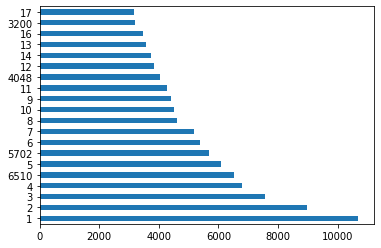

In [6]:
df_joined["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [7]:
#selecting reviews which were reviewed by more than 80 users
df_joined = df_joined.sort_values(by='num_reviewers', ascending=False)
df_joined_above_50 = df_joined[df_joined.num_reviewers >= 80]
df_joined_above_50.head()

,overall_x,vote_x,verified_x,reviewTime_x,reviewerID_x,asin,style_x,reviewerName_x,reviewText_x,summary_x,...,reviewerID_y,style_y,reviewerName_y,reviewText_y,summary_y,unixReviewTime_y,image_y,num_reviewers,total_score,review_summary
31028,5,NaN,True,"05 14, 2010",A1JCC2Y0H3WZ6C,B000AST3AK,NaN,Marilyn,I should replace my filter every six months. ...,Great filter - the model that goes with my frig.,...,6510,0,6510,6509,6510,6510,46,6510,5,Great filter - the model that goes with my frig.
26820,5,NaN,True,"01 26, 2016",A3P5T4JL9U1WEW,B000AST3AK,NaN,T Parker,I buy this item for my fridge and it works per...,Five Stars,...,6510,0,6510,6509,6510,6510,46,6510,5,Five Stars
26810,5,NaN,True,"01 28, 2016",A2EJBRKGIQN7S,B000AST3AK,NaN,Larry Sharland,Just ordered another one. Works great.,Works great.,...,6510,0,6510,6509,6510,6510,46,6510,5,Works great.
26811,5,NaN,True,"01 28, 2016",A2EMRFKM5DPBFR,B000AST3AK,NaN,Amazon Customer,This item was just as described. it does come...,Mmmmm Water,...,6510,0,6510,6509,6510,6510,46,6510,5,Mmmmm Water
26812,1,NaN,True,"01 27, 2016",A34C4IC39BHMUE,B000AST3AK,NaN,Amazon Customer,Comes with white generic box,One Star,...,6510,0,6510,6509,6510,6510,46,6510,1,One Star


<AxesSubplot:>

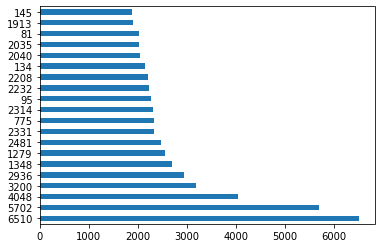

In [8]:
df_joined_above_50["num_reviewers"].value_counts()[:20].plot(kind='barh')

In [9]:
#making final product reviews dataset
df_product = df.groupby("asin", as_index=False).mean()
df_product_review = df_joined_above_50.groupby("asin")["review_summary"].apply(list)
df_product_review = pd.DataFrame(df_product_review)
df_product_review.to_csv("appliances_product_summary.csv")

In [10]:
df_product_review.head()

,review_summary
asin,
B00004YWK2,"[Awesomesauce, Works Fantastic, Should have do..."
B00005OU6T,"[Five Stars, Very efficient, but degrades quic..."
B00006IV17,"[Four Stars, Four Stars, Five Stars, Five Star..."
B00007E7RQ,"[Five Stars, it only lasted 1 and 1/2, Five St..."
B00009W3HD,[You have to watch the water level but it's ea...


In [11]:
#merging
df_product_review = pd.read_csv("appliances_product_summary.csv")
df_product_review = pd.merge(df_product_review, df_product, on="asin", how='inner')

In [12]:
df_product_review = df_product_review[['asin','review_summary','overall']]
df_product_review.head()

,asin,review_summary,overall
0,B00004YWK2,"['Awesomesauce', 'Works Fantastic', 'Should ha...",3.908046
1,B00005OU6T,"['Five Stars', ""Very efficient, but degrades q...",3.820000
2,B00006IV17,"['Four Stars', 'Four Stars', 'Five Stars', 'Fi...",4.326797
3,B00007E7RQ,"['Five Stars', 'it only lasted 1 and 1/2', 'Fi...",4.126531
4,B00009W3HD,"[""You have to watch the water level but it's e...",3.745583


In [13]:
df_ranges = pd.crosstab(df_product_review['asin'], pd.cut(df_product_review['overall'], [2, 2.5, 3.0, 3.5, 4.0, 4.5, 5]))
df_ranges.head()

overall,"(2.0, 2.5]","(2.5, 3.0]","(3.0, 3.5]","(3.5, 4.0]","(4.0, 4.5]","(4.5, 5.0]"
asin,,,,,,
B00004YWK2,0,0,0,1,0,0
B00005OU6T,0,0,0,1,0,0
B00006IV17,0,0,0,0,1,0
B00007E7RQ,0,0,0,0,1,0
B00009W3HD,0,0,0,1,0,0


<AxesSubplot:xlabel='overall'>

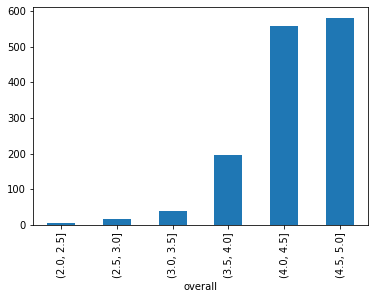

In [14]:
df_ranges.sum().plot.bar()

<AxesSubplot:>

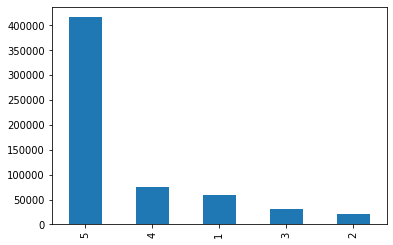

In [15]:
df['overall'].value_counts().plot(kind='bar')

### *Step 4: Text Cleaning*

In [16]:
#tokenizing text
reg = re.compile('[^a-z]+')
def cleanText(text):
    text = text.lower()
    text = reg.sub(' ', text).strip()
    return text

In [17]:
#drop duplicate rows
df_product_review["cleaned_review"] = df_product_review["review_summary"].apply(cleanText)
df_product_review = df_product_review.drop_duplicates(['overall'], keep='last')
df_product_review = df_product_review.reset_index()

In [18]:
#count vectorization
reviews = df_product_review["cleaned_review"] 
countVector = CountVectorizer(max_features = 200, stop_words='english') 
transformed_reviews = countVector.fit_transform(reviews) 

df_reviews = DataFrame(transformed_reviews.A, columns=countVector.get_feature_names())
df_reviews = df_reviews.astype(int)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
#save 
df_reviews.to_csv("appliances_reviews.csv")

### *Step 5: Train Test Split*

In [22]:
X = np.array(df_reviews)
train_test_ratio = 0.9
size = int(np.floor(train_test_ratio * len(X)))
X_train = X[:size]
X_test = X[size:]

In [23]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)
distances, indices = neighbor.kneighbors(X_train)

### Step 6: *Finding related products*

In [24]:
#find most related products
for i in range(len(X_test)):
    product_test = neighbor.kneighbors([X_test[i]])
    related_products = a[1]

    related_product_1 = [item[0] for item in related_products]
    related_product_1 = str(related_product_1).strip('[]')
    related_product_1 = int(related_product_1)
    
    related_product_2 = [item[1] for item in related_products]
    related_product_2 = str(related_product_2).strip('[]')
    related_product_2 = int(related_product_2)
    
    print ("Based on product reviews, for ", df_product_review["asin"][len(X_train) + i] ," average rating is ",df_product_review["overall"][lentrain + i])
    print ("The first similar product is ", df_product_review["asin"][related_product_1] ," average rating is ",df_product_review["overall"][related_product_1])
    print ("The second similar product is ", df_product_review["asin"][related_product_2] ," average rating is ",df_product_review["overall"][related_product_2])
    print ("-----------------------------------------------------------")

NameError: name 'a' is not defined

In [25]:
y_train = df_product_review["overall"][:len(X_train)].apply(np.ceil)
y_test = df_product_review["overall"][len(X_train):len(X_train)+len(X_test)].apply(np.ceil)

### *Over Sampling*

<AxesSubplot:>

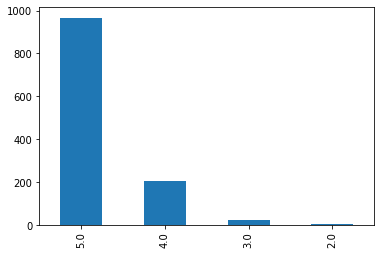

In [26]:
#before over sampling
y_train.value_counts().plot(kind='bar')

In [27]:
# over = SMOTE(k_neighbors=3)
# X_train, y_train = over.fit_resample(X_train, y_train)

In [28]:
# #after over sampling
# y_train.value_counts().plot(kind='bar')

### *Apply kNN*

In [29]:
clf = neighbors.KNeighborsClassifier(3, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         4.0       0.59      0.57      0.58        23
         5.0       0.91      0.92      0.91       110

    accuracy                           0.86       133
   macro avg       0.75      0.74      0.75       133
weighted avg       0.85      0.86      0.86       133



In [30]:
print (accuracy_score(y_test, pred))
print(mean_squared_error(y_test, pred))

0.8571428571428571
0.14285714285714285


In [31]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanText)

In [32]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

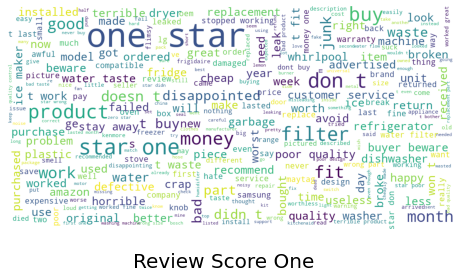

In [33]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

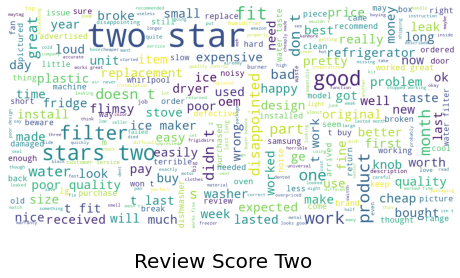

In [34]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Score Two")

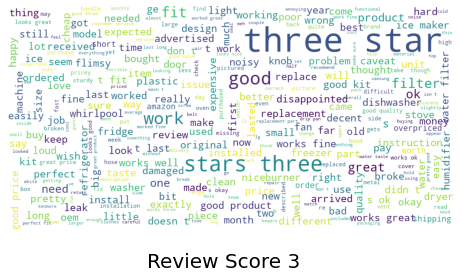

In [35]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score 3")

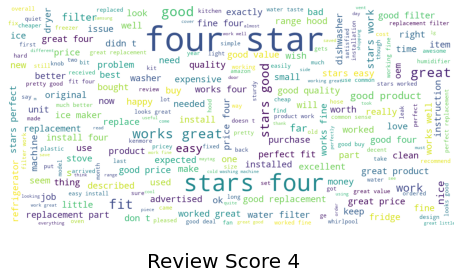

In [36]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score 4")

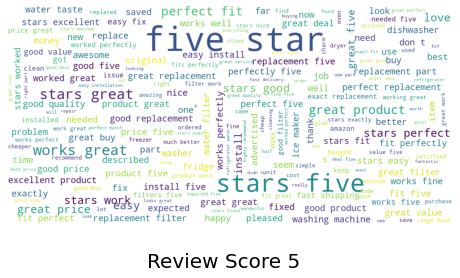

In [37]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score 5")

In [38]:
errors = []
K = range(1,10)
for k in K:
    model  = neighbors.KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    errors.append(mean_squared_error(y_test, pred))

Text(0, 0.5, 'Error Rate')

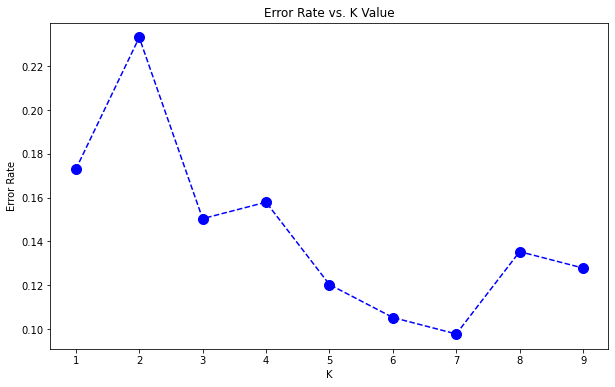

In [39]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10), errors, color='blue', linestyle='dashed', marker='o', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [40]:
clf = neighbors.KNeighborsClassifier(7, weights='distance')
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

print(classification_report(y_test, pred))
print ("Accuracy: ",accuracy_score(y_test, pred))
print("MSE: ",mean_squared_error(y_test, pred))

              precision    recall  f1-score   support

         4.0       0.86      0.52      0.65        23
         5.0       0.91      0.98      0.94       110

    accuracy                           0.90       133
   macro avg       0.88      0.75      0.80       133
weighted avg       0.90      0.90      0.89       133

Accuracy:  0.9022556390977443
MSE:  0.09774436090225563
